# Cox models: Introduction

In this notebook we will train three Cox models with neural networks:

- Cox CC: a proportional hazards model trainied with case-control sampling.
- Cox DeepSurv: a proportional hazards model more or less identical to DeepSurv.
- Cox-Time: a non-poportional case-control model. 

The Cox CC and DeepSurv models are very similar, with the Cox-Time model is a littel more flexible.

We will use the METABRIC data sets as an example

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from pycox import datasets
from pycox.models import CoxCC, CoxPH, CoxTime
from pycox.evaluation import EvalSurv
from torchtuples import tuplefy, optim
from torchtuples import callbacks as cb
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

`sklearn_pandas` can be installed with `! pip install sklearn-pandas`

In [2]:
np.random.seed(1234)
_ = torch.manual_seed(123)

## Dataset

We load the METABRIC data set and split in train, test and validation.

In [3]:
df_train = datasets.metabric.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [4]:
df_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,99.333336,0
1,5.284882,9.581043,10.204620,5.664970,1.0,0.0,0.0,1.0,85.940002,95.733330,1
3,6.654017,5.341846,8.646379,5.655888,0.0,0.0,0.0,0.0,66.910004,239.300003,0
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998,56.933334,1
5,5.425826,6.331182,10.455145,5.749053,1.0,1.0,0.0,1.0,70.519997,123.533333,0


## Feature transforms
We have 9 covariates, in addition to the durations and event indicators.

We will standardize the 5 numerical covariates, and leave the binary variables as is. As variables needs to be of type `'float32'`, as this is required by pytorch.

In [5]:
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [6]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

The targets (durations and events) also needs to be arrays of type `'float32'`.

In [7]:
get_target = lambda df: (df['duration'].values.astype('float32'), df['event'].values.astype('float32'))

In [8]:
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)

We collect the valiation data in a tuple with `tuplefy`. 

In [9]:
val = tuplefy(x_val, y_val) 

This allows us to fake a larger validation data set by repeating the dataset multiple times. Here we just show how we can repeat the set 3 times

In [10]:
val.shapes()

((305, 9), ((305,), (305,)))

In [11]:
val.repeat(3).cat().shapes()

((915, 9), ((915,), (915,)))

## Neural net

We make a torch net. If this is new to you, we would recommend [the tutorials by PyTroch](https://pytorch.org/tutorials/).

We create a simple MLP with two hidden layers, relu activations, batch norm and dropout.


In [12]:
class NetMLP(nn.Module):
    def __init__(self):
        super().__init__()
        input_size = 9
        nodes = 32
        self.block0 = nn.Sequential(nn.Linear(input_size, nodes), nn.ReLU(),
                                    nn.BatchNorm1d(nodes), nn.Dropout(0.1))
        self.block1 = nn.Sequential(nn.Linear(nodes, nodes), nn.ReLU(),
                                    nn.BatchNorm1d(nodes), nn.Dropout(0.1))
        self.out = nn.Linear(32, 1, bias=False)

    def forward(self, x):
        x = self.block0(x)
        x = self.block1(x)
        x = self.out(x)
        return x

We have also added a similar network structure to this in `torchtuples.practical`.
Uncomment the following to get a similar network

In [13]:
# from torchtuples.practical import MLPVanilla
# net = MLPVanilla(9, [32, 32], 1, True, 0.1)

# Cox CC

Now we can fit the model. We make the network and define the optimzer.

The `torchtuples.optim.Adam` optimizer is a wrapper to `torch.optim.Adam` that allows us to add some extra functionallity. You can instead just used the `torch.optim` optimizers if desired.

In [14]:
net = NetMLP()
# net = MLPVanilla(9, [32, 32], 1, True, 0.1)
optimizer = optim.Adam(lr=0.001)
cox_cc = CoxCC(net, optimizer)

We make an EarlyStopping callbacks that stopps the trainig progress when the validation loss has not improved the last 10 epochs.
It also checkpoints the model, and loads the best performing model after finished iterating.

We can now fit the Cox CC model, where we have added 10 replicates of our validation data (this makes the validation loss a little more stable).

In [15]:
es = cb.EarlyStopping()
log = cox_cc.fit(x_train, y_train, batch_size=128, epochs=60, callbacks=[es], val_data=val.repeat(10).cat())

0:	[0s / 0s],		train_loss: 0.7160,	val_loss: 0.6922
1:	[0s / 0s],		train_loss: 0.6799,	val_loss: 0.6894
2:	[0s / 0s],		train_loss: 0.6702,	val_loss: 0.6845
3:	[0s / 0s],		train_loss: 0.6677,	val_loss: 0.6764
4:	[0s / 0s],		train_loss: 0.6473,	val_loss: 0.6704
5:	[0s / 0s],		train_loss: 0.6445,	val_loss: 0.6637
6:	[0s / 0s],		train_loss: 0.6469,	val_loss: 0.6666
7:	[0s / 0s],		train_loss: 0.6245,	val_loss: 0.6553
8:	[0s / 0s],		train_loss: 0.6579,	val_loss: 0.6583
9:	[0s / 0s],		train_loss: 0.6385,	val_loss: 0.6475
10:	[0s / 0s],		train_loss: 0.6379,	val_loss: 0.6565
11:	[0s / 0s],		train_loss: 0.6145,	val_loss: 0.6534
12:	[0s / 0s],		train_loss: 0.6287,	val_loss: 0.6531
13:	[0s / 0s],		train_loss: 0.6428,	val_loss: 0.6540
14:	[0s / 0s],		train_loss: 0.6255,	val_loss: 0.6538
15:	[0s / 0s],		train_loss: 0.6212,	val_loss: 0.6368
16:	[0s / 1s],		train_loss: 0.6127,	val_loss: 0.6398
17:	[0s / 1s],		train_loss: 0.6075,	val_loss: 0.6374
18:	[0s / 1s],		train_loss: 0.6271,	val_loss: 0.6568
19:

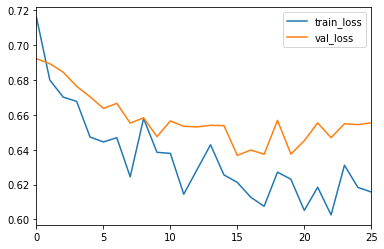

In [16]:
_ = log.plot()

If we want to investigate the partial log-likelihood:

In [17]:
cox_cc.partial_log_likelihood(*val).mean()

-5.000345706939697

#### Prediction

We can call the method `predict_survival_function` to obtain survival predicitons, however we first need to fit the non-parametric baseline hazard function. 
As compuation of baseline hazards can be quite computational for larger data sets, you need to call this explicitly (on e.g. a subset of the training set). 
If no arguments are passed to the `compute_baseline_hazards` method, it will use the full training set.

In [18]:
surv_cc = cox_cc.predict_survival_function(x_test)  # will give an Error

ValueError: Need to compute baseline_hazards_. E.g run `model.compute_baseline_hazards()`

In [19]:
_ = cox_cc.compute_baseline_hazards()

In [20]:
surv_cc = cox_cc.predict_survival_function(x_test)

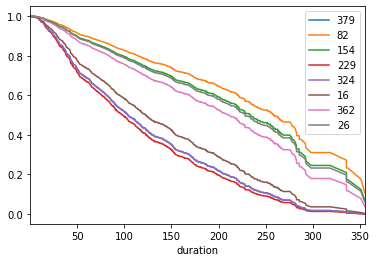

In [21]:
_ = surv_cc.sample(8, axis=1).plot()

#### Evaluation

We can use the `EvalSurv` class for evaluation the concordance, brier score and binomial log-likelihood. Setting `censor_surv='km'` means that we estimate the censoring distribution by Kaplan-Meier on the test set.

In [22]:
ev_cox_cc = EvalSurv(surv_cc, durations_test, events_test, censor_surv='km')

In [23]:
ev_cox_cc.concordance_td()

0.6666807933548059

/Users/havard/packages/pycox/pycox/evaluation/ipcw.py:52: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(scores, axis=1) / np.sum(weights, axis=1)


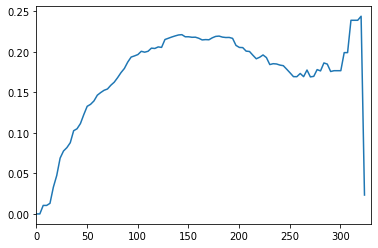

In [24]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev_cox_cc.brier_score(time_grid).plot()

We see that there are some instatilities at the end. This is because there are very few individuals alive here. Hence we make a new `time_grid` that exclude the last part.

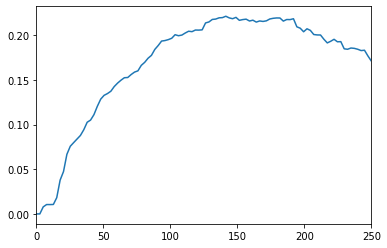

In [25]:
time_grid = np.linspace(durations_test.min(), 250, 100)
_ = ev_cox_cc.brier_score(time_grid).plot()

In [26]:
ev_cox_cc.integrated_brier_score(time_grid), ev_cox_cc.integrated_mbll(time_grid)

(0.16877665320905055, -0.5025647259210938)

# Cox DeepSurv

We now fit a DeepSurv model that is very similar to CoxCC, so we basically just repeat the steps.

Note that as we now optimize the partial log-likelihood, we have no need to repeat the valiation data set as the score is deterministic. 

Also note that because the trainig set and validation set are not of equal size (train is 4 times larger), the partial log-likelihood is not comparable between the data sets (larger data sets gives smaller partial log-likelihood). Hence, we set the `val_batch_size` equal to the trining batch size, to obtain comparble training curves.

In [27]:
net = NetMLP()
cox_ph = CoxPH(net, optim.Adam(lr=0.001))
es = cb.EarlyStopping()
log = cox_ph.fit(x_train, y_train, batch_size=128, epochs=60, callbacks=[es], val_data=val, val_batch_size=128)
cox_ph.compute_baseline_hazards()
surv_ph = cox_ph.predict_survival_function(x_test)

0:	[0s / 0s],		train_loss: 4.0632,	val_loss: 3.8893
1:	[0s / 0s],		train_loss: 3.9958,	val_loss: 3.8668
2:	[0s / 0s],		train_loss: 3.9852,	val_loss: 3.8285
3:	[0s / 0s],		train_loss: 3.9562,	val_loss: 3.7940
4:	[0s / 0s],		train_loss: 3.9294,	val_loss: 3.7805
5:	[0s / 0s],		train_loss: 3.9309,	val_loss: 3.7761
6:	[0s / 0s],		train_loss: 3.9393,	val_loss: 3.7764
7:	[0s / 0s],		train_loss: 3.9142,	val_loss: 3.7769
8:	[0s / 0s],		train_loss: 3.9198,	val_loss: 3.7760
9:	[0s / 0s],		train_loss: 3.9284,	val_loss: 3.7744
10:	[0s / 0s],		train_loss: 3.9042,	val_loss: 3.7707
11:	[0s / 0s],		train_loss: 3.9173,	val_loss: 3.7744
12:	[0s / 0s],		train_loss: 3.9165,	val_loss: 3.7745
13:	[0s / 0s],		train_loss: 3.9142,	val_loss: 3.7739
14:	[0s / 0s],		train_loss: 3.9018,	val_loss: 3.7709
15:	[0s / 0s],		train_loss: 3.9044,	val_loss: 3.7710
16:	[0s / 1s],		train_loss: 3.8831,	val_loss: 3.7690
17:	[0s / 1s],		train_loss: 3.8941,	val_loss: 3.7762
18:	[0s / 1s],		train_loss: 3.8886,	val_loss: 3.7751
19:

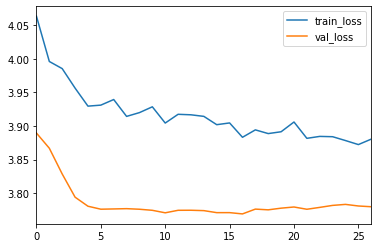

In [28]:
_ = log.plot()

In [29]:
ev_cox_ph = EvalSurv(surv_ph, durations_test, events_test, censor_surv='km')
ev_cox_ph.concordance_td()

0.6647948804882183

# Cox-Time

Next, we fit a Cox-Time model. This is a little different than the Cox CC and Cox DeepSurv, so we need to make some small alterations to our neural net.

In [30]:
class NetMLPCoxTime(nn.Module):
    def __init__(self):
        super().__init__()
        input_size = 9 + 1  # Need one more for time
        nodes = 32
        self.block0 = nn.Sequential(nn.Linear(input_size, nodes), nn.ReLU(),
                                    nn.BatchNorm1d(nodes), nn.Dropout(0.1))
        self.block1 = nn.Sequential(nn.Linear(nodes, nodes), nn.ReLU(),
                                    nn.BatchNorm1d(nodes), nn.Dropout(0.1))
        self.out = nn.Linear(32, 1, bias=False)

    def forward(self, x, t):  # need time in put
        x = torch.cat([x, t], dim=1)  # concatenate time with other covariates
        x = self.block0(x)
        x = self.block1(x)
        x = self.out(x)
        return x

Or we could again base our net on the `torchtuples.practical.MLPVanilla`:

In [31]:
# class NetMLPCoxTime(torch.nn.Module):
#     def __init__(self, in_features, num_nodes, out_features, batch_norm=True, dropout=None):
#         super().__init__()
#         self.net = MLPVanilla(in_features+1, num_nodes, out_features, batch_norm, dropout, output_bias=False)

#     def forward(self, x, t):
#         x = torch.cat([x, t], dim=1)
#         return self.net(x)

### Preprocessing

As we are now passing  time as a covariate to our network, we tupically need to standardize it.
We have added `LabTransCoxTime` which can do a log-transform and standardize the duration, while keeping track of the original durations (which is useful for predictions)

In [32]:
from pycox.preprocessing.label_transforms import LabTransCoxTime
labtrans = LabTransCoxTime()
y_train_cox_time = labtrans.fit_transform(*get_target(df_train))
y_val_cox_time = labtrans.transform(*get_target(df_val))
val = tuplefy(x_val, y_val_cox_time)

In [33]:
net = NetMLPCoxTime()
cox_time = CoxTime(net, optim.Adam(lr=0.001))

In [34]:
es = cb.EarlyStopping()
log = cox_time.fit(x_train, y_train_cox_time, epochs=60, callbacks=[es], val_data=tuplefy(val).repeat(10).cat())

0:	[0s / 0s],		train_loss: 0.7155,	val_loss: 0.6927
1:	[0s / 0s],		train_loss: 0.7086,	val_loss: 0.6913
2:	[0s / 0s],		train_loss: 0.6998,	val_loss: 0.6901
3:	[0s / 0s],		train_loss: 0.6875,	val_loss: 0.6876
4:	[0s / 0s],		train_loss: 0.6638,	val_loss: 0.6855
5:	[0s / 0s],		train_loss: 0.6649,	val_loss: 0.6828
6:	[0s / 0s],		train_loss: 0.6628,	val_loss: 0.6805
7:	[0s / 0s],		train_loss: 0.6553,	val_loss: 0.6728
8:	[0s / 0s],		train_loss: 0.6510,	val_loss: 0.6714
9:	[0s / 0s],		train_loss: 0.6409,	val_loss: 0.6636
10:	[0s / 0s],		train_loss: 0.6408,	val_loss: 0.6557
11:	[0s / 0s],		train_loss: 0.6226,	val_loss: 0.6569
12:	[0s / 0s],		train_loss: 0.6330,	val_loss: 0.6521
13:	[0s / 0s],		train_loss: 0.6365,	val_loss: 0.6533
14:	[0s / 0s],		train_loss: 0.6299,	val_loss: 0.6399
15:	[0s / 1s],		train_loss: 0.6358,	val_loss: 0.6422
16:	[0s / 1s],		train_loss: 0.6280,	val_loss: 0.6343
17:	[0s / 1s],		train_loss: 0.6223,	val_loss: 0.6362
18:	[0s / 1s],		train_loss: 0.6364,	val_loss: 0.6340
19:

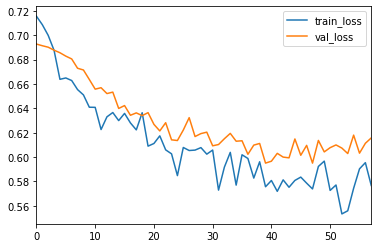

In [35]:
_ = log.plot()

### Predictions

If we just use predict in the same manner as before, we see that the durations (on the x-axis fo the plot) are still scaled.

In [36]:
_ = cox_time.compute_baseline_hazards()
surv_cox_time = cox_time.predict_survival_function(x_test)

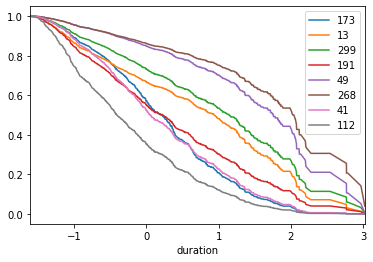

In [37]:
_ = surv_cox_time.sample(8, axis=1).plot()

To obtain the original duration scale, we can use the `labtrans` object:

In [38]:
surv_cox_time.index = labtrans.map_scaled_to_orig(surv_cox_time.index)

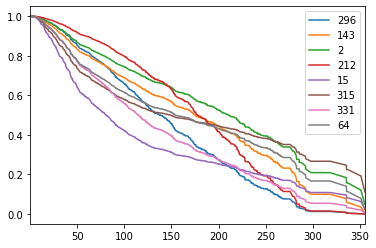

In [39]:
_ = surv_cox_time.sample(8, axis=1).plot()

In [40]:
ev_cox_time = EvalSurv(surv_cox_time, durations_test, events_test, censor_surv='km')

In [41]:
ev_cox_cc.concordance_td(), ev_cox_ph.concordance_td(), ev_cox_time.concordance_td()

(0.6666807933548059, 0.6647948804882183, 0.6732708933717579)

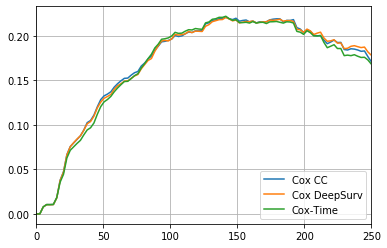

In [42]:
ev_cox_cc.brier_score(time_grid).rename('Cox CC').plot()
ev_cox_ph.brier_score(time_grid).rename('Cox DeepSurv').plot()
ev_cox_time.brier_score(time_grid).rename('Cox-Time').plot()
plt.legend()
plt.grid()

In [43]:
ev_cox_cc.integrated_brier_score(time_grid), ev_cox_ph.integrated_brier_score(time_grid), ev_cox_time.integrated_brier_score(time_grid)

(0.16877665320905055, 0.16848124177129836, 0.16671147729705982)

In [44]:
ev_cox_cc.integrated_mbll(time_grid), ev_cox_ph.integrated_mbll(time_grid), ev_cox_time.integrated_mbll(time_grid)

(-0.5025647259210938, -0.5009060947736069, -0.4943029028366378)